# Classification

In [3]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers

import json
import pandas as pd

import os
import time
os.environ["KERAS_BACKEND"] = "tensorflow"

## Pre-Processing

In [4]:
def GetTagIdDictionary(fullDatasetFileLocation):
    with open(fullDatasetFileLocation, 'r', encoding='utf-8') as f:
        fullDataset = json.load(f)
    
    uniqueTags = {'O': 0}
    
    i = 1
    for datapoint in fullDataset:
        for sentence in datapoint['sentences']:
            for variableName in sentence['variables'].keys():
                if variableName not in uniqueTags:
                    uniqueTags[variableName] = i
                    i+=1

    return uniqueTags

def GetTagIdToVariableDictionary(tagToIdDictionary):
    idToTagDictionary = {}
    for key in tagToIdDictionary.keys():
        idToTagDictionary[tagToIdDictionary[key]] = key
        
    return idToTagDictionary

tagToIdDictionary = GetTagIdDictionary("sources/atis.json")
idToTagDictionary = GetTagIdToVariableDictionary(tagToIdDictionary)

In [5]:
class Datasets:
    def __init__(self, trainingData, testingData, validationData):
        self.sqlTemplateToIds = self.GetUniqueSqlTemplatesFromTrainingSet(trainingData)
        self.AddIdColumns([trainingData, testingData, validationData])
        
        self.trainingData = pd.DataFrame(trainingData)
        self.testingData = pd.DataFrame(testingData)
        self.validationData = pd.DataFrame(validationData)
        
    
    def GetUniqueSqlTemplatesFromTrainingSet(self, trainingData):
        uniqueTemplates = {}
        i = 1
        for datapoint in trainingData:
            template = datapoint['sql-template']
            if template not in uniqueTemplates:
                uniqueTemplates[template] = i
                i+=1
                
        return uniqueTemplates
    
    def AddIdColumns(self, datasetsList):
        for dataset in datasetsList:
            self.AddSqlIdColumn(dataset)
            self.AddVariableIdColumn(dataset)
    
    def AddSqlIdColumn(self, dataset):
        for datapoint in dataset:
            sqlTemplate = datapoint["sql-template"]
            if sqlTemplate in self.sqlTemplateToIds:
                datapoint['sql-id'] = self.sqlTemplateToIds[sqlTemplate]
            else:
                datapoint['sql-id'] = 0
            
    def AddVariableIdColumn(self, dataset):
        for datapoint in dataset:
            tagList = []
            for tag in datapoint['tags']:
                tagId = tagToIdDictionary[tag]
                tagList.append(tagId)
            
            datapoint['tag-ids'] = tagList

In [6]:
def GetDatasets(fullDatasetFileLocation: str):
    with open(fullDatasetFileLocation, 'r', encoding='utf-8') as f:
        fullDataset = json.load(f)
    
    formattedDataset = StripAndFormat(fullDataset)
    
    QueryDatasets = GetSplit(formattedDataset, 'query-split')
    QuestionDatasets = GetSplit(formattedDataset, 'question-split')
    
    return QueryDatasets, QuestionDatasets

def StripAndFormat(dataset):
    formattedDataset = []
    ParseSentences(dataset)
    
    for datapoint in dataset:
        sqlTemplate = min(datapoint["sql"])
        for sentence in datapoint['sentences']:
            formattedDataset.append( {
                'text': sentence['text'],
                'full-text': sentence['full-text'],
                'sql-template': sqlTemplate,
                'tags': sentence['tags'],
                'query-split': datapoint['query-split'],
                'question-split': sentence['question-split']
                })
    
    return formattedDataset
    
def ParseSentences(dataset):
    for datapoint in dataset:
        for sentence in datapoint['sentences']:
            AddFullTextAndTags(sentence)
            
            
def AddFullTextAndTags(sentence):
    tags = []
    fullText = []
    words = sentence['text'].split(" ")
    for word in words:
        if word in sentence['variables']:
            replacementWords = sentence['variables'][word]
            fullText.append(replacementWords)
            wordList = replacementWords.split(" ")
            for _replacementWord in wordList:
                tags.append(word)
        else:
            tags.append('O')
            fullText.append(word)
            
    sentence['tags'] = tags
    sentence['full-text'] = " ".join(fullText)

def GetSplit(dataset, key):
    trainingData = []
    testingData = []
    validationData = []
    
    for datapoint in dataset:
        split = datapoint[key]
        match split:
            case "train":
                trainingData.append(datapoint)
            case "dev":
                validationData.append(datapoint)
            case "test":
                testingData.append(datapoint)
                
    return Datasets(trainingData, testingData, validationData)

In [7]:
QueryDatasets, QuestionDatasets = GetDatasets("sources/atis.json")


## Linear Model

Implementation from my submission for assignment 2 with minor alterations to handle this data

In [ ]:
class LinearModel:
    def initialiseWordWeights(self, word):
        for label in self.labels:
            self.weights[(word, label)] = 0

    def __init__(self, labels, training_data):
        """Prepare the class member variables.
        Save the labels in self.labels and initialise all the weights to 0.

        Keyword arguments:
        labels -- a set of strings, each string is one SQL query
        training_data -- a list, each item is a tuple containing a question and an SQL query
        """


        self.labels = labels
        self.weights = {}
        for datapoint in training_data:
            words = datapoint[0].split()
            for word in words:
                self.initialiseWordWeights(word)         
        
    def get_features(self, question, label):
        """Produce a list of features for a specific question and label.
        
        Keyword arguments:
        question -- a string, an English question
        label -- a string, an SQL query
        """
        features = []
        for word in question.split():
            features.append((word, label))
        return features

    def get_score(self, question, label):
        """Calculate the model's score for a question, label pair.
        
        Keyword arguments:
        question -- a string, an English question
        label -- a string, an SQL query
        """
        score = 0
        if label in self.labels:
            for word in question.split():
                if (word, label) in self.weights:
                    score += self.weights[(word,label)]

        return score

    def update(self, question, label, change):
        """Modify the model.
        Changes all weights for features for the (question, SQL query) pair by the amount indicated.

        Keyword arguments:
        question -- a string, an English question
        label -- a string, an SQL query
        change -- an integer, how much to change the weights
        """
        for word in question.split():
            self.weights[(word, label)] += change

def getBestScoringLabel(scoreDict, labels):
    maxScore = -9999999
    maxLabel = ""

    for label in labels:
        if scoreDict[label] > maxScore:
            maxLabel = label
            maxScore = scoreDict[label]

    return maxLabel

# This is the function you need to implement
def find_best_code(question, model):
    """Predicts the SQL for a question by using a model to try all possible labels.

    Keyword arguments:
    question -- a string, the English question
    model -- a CodeModel, as defined in the Model question
    """
    labelScoreDict = {}
    for label in model.labels:
        labelScoreDict[label] = model.get_score(question, label)
    
    return getBestScoringLabel(labelScoreDict, model.labels)


def learn(question, answer, model):
    """Updates a model by predicting the SQL for a question and making a Perceptron update 

    Keyword arguments:
    question -- a string, the English question
    answer -- a string, the correct SQL query for this question 
    model -- a CodeModel, as defined in the Model question
    find_best_code -- a function, the one defined the Inference question
    """
    best_score = find_best_code(question, model)
    if best_score != answer:
        model.update(question, answer, 1)
        model.update(question, best_score, -1)
    
# These are the functions you need to implement
def calculate_accuracy(confusion_matrix, labels):
    """Returns the accuracy based on the contents of a confusion matrix

    Keyword arguments:
    confusion_matrix -- a dictionary, as defined in the Confusion Matrix question
    labels -- a set of strings, all the possible labels
    """
    correctCount = 0
    total = 0
    for label1 in labels:
        for label2 in labels:
            if label1 == label2:
                correctCount += confusion_matrix[(label1, label2)]
            total += confusion_matrix[(label1, label2)]
    
    if total > 0:
        return correctCount / total
    else: 
        return 0
def calculate_precision(confusion_matrix, labels):
    """Returns a dict containing the precision for each label based on the contents of a confusion matrix

    Keyword arguments:
    confusion_matrix -- a dictionary, as defined in the Confusion Matrix question
    labels -- a set of strings, all the possible labels
    """
    precisionDictionary = {}
    for testLabel in labels:
        truePositives = 0
        falsePositives = 0
        for otherLabel in labels:
            if testLabel == otherLabel:
                truePositives += confusion_matrix[(testLabel, testLabel)]
            else:
                falsePositives += confusion_matrix[(otherLabel, testLabel)]
        
        total = truePositives + falsePositives
        if total > 0:
            precisionDictionary[testLabel] = truePositives / (total)
        else:
            precisionDictionary[testLabel] = 0
            

    return precisionDictionary

def calculate_recall(confusion_matrix, labels):
    """Returns a dict containing the recall for each label based on the contents of a confusion matrix

    Keyword arguments:
    confusion_matrix -- a dictionary, as defined in the Confusion Matrix question
    labels -- a set of strings, all the possible labels
    """
    recallDictionary = {}
    for testLabel in labels:
        truePositives = 0
        falseNegatives = 0
        for otherLabel in labels:
            if testLabel == otherLabel:
                truePositives += confusion_matrix[(testLabel, testLabel)]
            else:
                falseNegatives += confusion_matrix[(testLabel, otherLabel)]
        
        total = truePositives + falseNegatives
        if total > 0:
            recallDictionary[testLabel] = truePositives / (truePositives + falseNegatives)
        else:
            recallDictionary[testLabel] = 0

    return recallDictionary

def calculate_macro_f1(confusion_matrix, labels):
    """Returns the Macro F-Score based on the contents of a confusion matrix

    Keyword arguments:
    confusion_matrix -- a dictionary, as defined in the Confusion Matrix question
    labels -- a set of strings, all the possible labels
    """
    precisionMetrics = calculate_precision(confusion_matrix, labels)
    recallMetrics = calculate_recall(confusion_matrix, labels)

    f1Total = 0
    for label in labels:
        precisionScore = precisionMetrics[label]
        recallScore = recallMetrics[label]
        
        denominator = precisionScore + recallScore
        if denominator != 0:
            f1Score = 2 * ((precisionScore * recallScore) / (precisionScore + recallScore))
            f1Total += f1Score

    return f1Total / len(labels)

def initializeConfusionMatrix(labels):
    confusionMatrix = {}
    for label1 in labels:
        for label2 in labels:
            confusionMatrix[(label1, label2)] = 0
            confusionMatrix[('unknown', label2)] = 0
    return confusionMatrix

# This is the function you need to implement
def get_confusion_matrix(eval_data, model):
    """Creates a confusion matrix by predicting the SQL for a question and recording how the answer compares with the true answer 

    Keyword arguments:
    eval_data -- a list of tuples containing the English question and the true SQL query
    model -- a CodeModel, as defined in the Model question
    find_best_code -- a function, the one defined the Inference question
    """
    confusionMatrix = initializeConfusionMatrix(model.labels)
    for datapoint in eval_data:
        trueAnswer = datapoint[1]
        predictedAnswer = find_best_code(datapoint[0], model)
        if (trueAnswer, predictedAnswer) in confusionMatrix:
            confusionMatrix[(trueAnswer, predictedAnswer)] += 1

    return confusionMatrix

def TrainAndEvaluateModel(model, iterations, trainData, validationData, testData):
    """Trains and evaluates a model on some read_data

    Keyword arguments:
    filename -- a string, the location of a json file containing data
    iterations -- an integer, the number of iterations of training to do
    read_data -- a function, as defined in the Data question
    model_maker -- a class, as defined in the Model question
    learn -- a function, as defined in the Learning question
    find_best_code -- a function, as defined in the Inference question
    get_confusion_matrix -- a function, as defined in the Confusion Matrix question
    calculate_accuracy -- a function, as defined in the Evaluation Metrics question
    calculate_macro_f1 -- a function, as defined in the Evaluation Metrics question
    """

    dev_scores = []
    i = 0
    while i < iterations:
        for datapoint in trainData:
            learn(datapoint[0], datapoint[1], model)
        
        confusionMatrix = get_confusion_matrix(validationData, model)
        devScore = {}
        devScore["accuracy"] = calculate_accuracy(confusionMatrix, model.labels)
        devScore["macro-f1"] = calculate_macro_f1(confusionMatrix, model.labels)

        dev_scores.append(devScore)
        i+=1

    confusionMatrix = get_confusion_matrix(testData, model)
    test_score = {}
    test_score["accuracy"] = calculate_accuracy(confusionMatrix, model.labels)
    test_score["macro-f1"] = calculate_macro_f1(confusionMatrix, model.labels)

    return dev_scores, test_score

train models

In [ ]:
def getFullWordList(allSentences):
    longSentence = " ".join(allSentences)
    return longSentence.split(" ")

def flatten(xss):
    return [x for xs in xss for x in xs]

def FormatFeatureLabelPairs(features, labels):
    pairs = []
    print(len(features))
    print(len(labels))
    
    i = 0
    while i < len(features):
        pairs.append((features[i], labels[i]))
        i+=1
    return pairs

def GetTagPairs(dataset):
    fullWordList = getFullWordList(dataset['full-text'])
    flattenedTags = flatten(dataset['tags'])
    
    return FormatFeatureLabelPairs(fullWordList, flattenedTags)

def GetSqlLabels(allSentences, allTemplates):
    sqlLabels = []
    
    i = 0
    while i < len(allSentences):
        sentence = allSentences[i]
        words = sentence.split(" ")
        for _word in words:
            sqlLabels.append(allTemplates[i])
        i+=1
        
    return sqlLabels

def GetSqlPairs(dataset):
    fullWordList = getFullWordList(dataset['full-text'])
    sqlLabels = GetSqlLabels(dataset['full-text'], dataset['sql-template'])
    
    return FormatFeatureLabelPairs(fullWordList, sqlLabels)

def EvaluateLinearModels(datasets: Datasets):
    allVariables = tagToIdDictionary.keys()
    

    trainingTagPairs = GetTagPairs(datasets.trainingData)
    trainingSqlPairs = GetSqlPairs(datasets.trainingData)
    
    validationTagPairs = GetTagPairs(datasets.validationData)
    validationSqlPairs = GetSqlPairs(datasets.validationData)
    
    testingTagPairs = GetTagPairs(datasets.testingData)
    testingSqlPairs = GetSqlPairs(datasets.testingData)

    tagModel = LinearModel(allVariables, trainingTagPairs)
    sqlModel = LinearModel(datasets.sqlTemplateToIds.keys(), trainingSqlPairs)

    devScores, sqlTestScores = TrainAndEvaluateModel(sqlModel, 15, trainingSqlPairs, validationSqlPairs, testingSqlPairs)
    print("sql test scores:")
    print(sqlTestScores)
    
    devScores, tagTestScores = TrainAndEvaluateModel(tagModel, 15, trainingTagPairs, validationTagPairs, testingTagPairs)
    print("tag test scores:")
    print(tagTestScores)
    

    
    return tagModel, sqlModel

questionTagModel, questionModel = EvaluateLinearModels(QuestionDatasets)

TrainAndEvaluateModel()

47754
47754
47754
47754
5366
5366
5366
5366
4240
4240
4240
4240


KeyboardInterrupt: 

## Feed Forward

In [ ]:
""" def getMaxSentence(datasets):
    maxSentence = -1

    for datapoint in datasets.trainingData:
        words = datapoint['full-text'].split()
        sentenceLength = len(words)
        if sentenceLength > maxSentence:
            maxSentence = sentenceLength
    return maxSentence

 """

In [10]:
MAX_FEATURES = 20000
MAX_SEQUENCE = 50
EMBEDDING_DIMENSIONS = 120


### Prepare Inputs

In [13]:
def GetVectorizationLayer(datasets: Datasets):
    vectorizeLayer = keras.layers.TextVectorization(
        standardize='lower',
        max_tokens=MAX_FEATURES,
        output_mode="int",
        output_sequence_length=MAX_SEQUENCE
    )
    
    vectorizeLayer.adapt(datasets.trainingData['full-text'])
    return vectorizeLayer

def vectorizeAllText(dataset):
    return list(dataset['full-text'].map(vectorizeText))

def vectorizeText(text):
    return list(sqlVectorizationLayer(text))

    
sqlVectorizationLayer = GetVectorizationLayer(QuestionDatasets)

"""
queryVectorSqlTrainingPairs = GetVectorSqlPairs(QueryDatasets.trainingData)
queryVectorSqlTestingPairs = GetVectorSqlPairs(QueryDatasets.testingData)
queryVectorSqlValidationPairs = GetVectorSqlPairs(QueryDatasets.validationData)
"""
""" def GetVectorSqlPairs(dataset):
    vectorizedSentences = []
    tfDataset = tf.data.Dataset.from_tensor_slices((dataset['full-text'], dataset['sql-id']))
    return tfDataset.map(vectorizeText)

def GetVectorTagPairs(dataset, vectorizeLayer):
    fullWordList = getFullWordList(dataset['full-text'])
    flattenedTags = flatten(dataset['tag-ids'])
    vectorizedWords = map(lambda word: vectorizeText(word, vectorizeLayer), [word for word in fullWordList])
    
    return FormatFeatureLabelPairs(vectorizedWords, flattenedTags) """


" def GetVectorSqlPairs(dataset):\n    vectorizedSentences = []\n    tfDataset = tf.data.Dataset.from_tensor_slices((dataset['full-text'], dataset['sql-id']))\n    return tfDataset.map(vectorizeText)\n\ndef GetVectorTagPairs(dataset, vectorizeLayer):\n    fullWordList = getFullWordList(dataset['full-text'])\n    flattenedTags = flatten(dataset['tag-ids'])\n    vectorizedWords = map(lambda word: vectorizeText(word, vectorizeLayer), [word for word in fullWordList])\n    \n    return FormatFeatureLabelPairs(vectorizedWords, flattenedTags) "

In [14]:
vectorizedTrainingText = vectorizeAllText(QuestionDatasets.trainingData)
vectorizedValidationText = vectorizeAllText(QuestionDatasets.validationData)
vectorizedTestingText = vectorizeAllText(QuestionDatasets.testingData)

In [15]:
def flattenAndRemovePadding(vectorizedText):
    tokens = []
    for sentence in vectorizedText:
        for token in sentence:
            if token != 0:
                tokens.append(token)
    return tokens

tagVectorizedTrainingText: list[int] = flattenAndRemovePadding(vectorizedTrainingText)
tagVectorizedValidationText = flattenAndRemovePadding(vectorizedValidationText)
tagVectorizedTestingText = flattenAndRemovePadding(vectorizedTestingText)

In [ ]:
print(len(flatten(QuestionDatasets.trainingData['tags'])))
print(len(np.array(tagVectorizedTrainingText)))
print(np.array(tagVectorizedTrainingText, dtype=np.int32)[0])
print(flatten(QuestionDatasets.trainingData['tags'])[0])

print(np.array(tagVectorizedTrainingText, dtype=np.int32).dtype)

47754
47754
28
O
int32


In [16]:
def GetLabels(tags):
    flattenedTags = flatten(tags)
    tagTrainingLabels = []
    for label in flattenedTags:
        tagTrainingLabels.append(tagToIdDictionary[label])
    
    return tagTrainingLabels

tagTrainingLabels = GetLabels(QuestionDatasets.trainingData['tags'])
tagValidationLabels = GetLabels(QuestionDatasets.validationData['tags'])
tagTestingLabels = GetLabels(QuestionDatasets.testingData['tags'])

In [ ]:
print(QueryDatasets.validationData['sql-id'])

0      0
1      0
2      0
3      0
4      0
      ..
116    0
117    0
118    0
119    0
120    0
Name: sql-id, Length: 121, dtype: int64


### Models

In [17]:
def GetSqlNNModel(datasets):
    numClasses  = len(QuestionDatasets.sqlTemplateToIds.keys()) + 1

    # Model definition
    inputs = keras.Input(shape=(None,), dtype="int64")
    x = layers.Embedding(MAX_FEATURES, EMBEDDING_DIMENSIONS)(inputs)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    #x = layers.Dropout(.5)(x)
    x = layers.Dense(128, activation="relu")(x)
    #x = layers.Dropout(.5)(x)
    outputs = layers.Dense(numClasses, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",  # for integer labels
        metrics=["accuracy"]
    )
    return model

def GetTagNNModel():
    numClasses = len(tagToIdDictionary.keys())

    # Model definition
    inputs = keras.Input(shape=(1,), dtype="int64")
    x = layers.Embedding(MAX_FEATURES, EMBEDDING_DIMENSIONS)(inputs)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(8, activation="relu")(x)
    #x = layers.Dropout(.5)(x)
    #x = layers.Dense(8, activation="relu")(x)
    #x = layers.Dropout(.5)(x)
    outputs = layers.Dense(numClasses, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",  # for integer labels
        metrics=["accuracy"]
    )
    return model

In [ ]:
print(len(QuestionDatasets.sqlTemplateToIds.keys()) + 1)

821


### training Models

In [ ]:
# Fit the model
sqlNNModel = GetSqlNNModel(QuestionDatasets)
tagNNModel = GetTagNNModel()

sqlHistory = sqlNNModel.fit(x=np.array(vectorizedTrainingText), y=QuestionDatasets.trainingData['sql-id'], validation_data=(np.array(vectorizedValidationText), QuestionDatasets.validationData['sql-id']), epochs=50)
tagHistory = tagNNModel.fit(x=np.array(tagVectorizedTrainingText), y=np.array(tagTrainingLabels), validation_data=(np.array(tagVectorizedValidationText), np.array(tagValidationLabels)), batch_size=128, epochs=20)

In [ ]:
model.evaluate(x= np.array(vectorizedTestingText), y=QuestionDatasets.testingData['sql-id'])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6720 - loss: 3.6830 


[10.667848587036133, 0.3959731459617615]

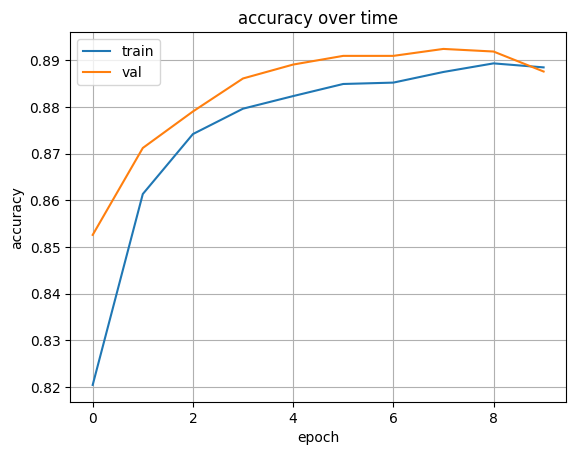

In [ ]:
import matplotlib.pyplot as pyplot
    
def plotChange(history):
    pyplot.title('accuracy over time')
    pyplot.plot(history['accuracy'])
    pyplot.plot(history['val_accuracy'])
    pyplot.xlabel('epoch')
    pyplot.ylabel('accuracy')
    pyplot.legend(['train', 'val'], loc='upper left')
    pyplot.grid(True)
    pyplot.show()
        
    pyplot.show()
    
plotChange(sqlHistory.history)
plotChange(tagHistory.history)

## LSTM

In [ ]:
def GetLSTMModel(datasets: Datasets):
    numTags = len(tagToIdDictionary.keys())
    numClasses = len(datasets.sqlTemplateToIds.keys()) + 1

    # Model definition
    inputs = keras.Input(shape=(None,), dtype="int64")
    x = layers.Embedding(MAX_FEATURES, EMBEDDING_DIMENSIONS)(inputs)
    #x = layers.GlobalAveragePooling1D()(x)
    x = layers.LSTM(64, return_sequences=True)(x)
    lstm_out, state_h, _state_c = layers.LSTM(64, return_sequences=True, return_state=True)(x)
    
    tagOutput = layers.TimeDistributed(layers.Dense(numTags, activation='softmax'))(lstm_out)
    template_output = layers.Dense(numClasses, activation='softmax')(state_h)
    #x = layers.Dropout(.5)(x)
    #x = layers.Dense(8, activation="relu")(x)
    #x = layers.Dropout(.5)(x)
    model = keras.Model(inputs=inputs, outputs=(tagOutput, template_output))
    # Compile the model
    model.compile(
        optimizer="adam",
        loss='sparse_categorical_crossentropy',  # for integer labels
        metrics=["accuracy", "accuracy"]
    )
    return model

print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [ ]:
LSTMModel = GetLSTMModel(QuestionDatasets)

In [ ]:
def combineTags(y_tags, y_templates):
    combined = []
    i = 0
    while i < 1000:
        combined.append((y_tags[i], y_templates[i]))
        i+=1
    return combined



input_length = 20
input_dim = 2
num_tags = len(tagToIdDictionary.keys())
num_templates = len(QuestionDatasets.sqlTemplateToIds.keys()) + 1


X_train = np.random.rand(1000, input_length)  # 1000 samples
y_tags = np.random.randint(0, num_tags, (1000, input_length))  # Tags for each timestep
y_templates = np.random.randint(0, num_templates, 1000)  # Template for the sequence

# One-hot encode the tags and templates
y_tags_one_hot = keras.utils.to_categorical(y_tags, num_tags)
y_templates_one_hot = keras.utils.to_categorical(y_templates, num_templates)

tagIdArray = np.array(QuestionDatasets.trainingData['tag-ids'])
sqlIdArray = np.array(QuestionDatasets.trainingData['sql-id'])

LSTMModel.fit(x=np.array(vectorizedTrainingText), y=(tagIdArray, sqlIdArray), epochs=10, batch_size=32)

NameError: name 'tagToIdDictionary' is not defined

In [ ]:
def GetTagNumpyArray(dataset):
    result = []
    i = 0
    for ids in dataset['tag-ids']:
        length = len(ids)
        result.append(np.pad(ids, (0, 50-length)))
        i+=1
    
    return np.array(result)

trainingTagIdArray = GetTagNumpyArray(QuestionDatasets.trainingData)
trainingSqlIdArray = np.array(QuestionDatasets.trainingData['sql-id'])

validationTagIdArray = GetTagNumpyArray(QuestionDatasets.validationData)
validationSqlIdArray = np.array(QuestionDatasets.validationData['sql-id'])

print(tagIdArray.dtype)
LSTMModel.fit(x=np.array(vectorizedTrainingText), y=(trainingTagIdArray , trainingSqlIdArray), validation_data=(vectorizedValidationText, (validationTagIdArray, validationSqlIdArray)), epochs=20, batch_size=32)

int32
Epoch 1/20
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - dense_100_accuracy: 0.3354 - dense_100_loss: 3.4172 - loss: 3.4703 - time_distributed_20_accuracy: 0.9758 - time_distributed_20_loss: 0.0530

IndexError: tuple index out of range

## Transformer

In [ ]:
def GetTransformer(datasets): 
    NUM_HEADS = 3
    KEY_DIMENSION = 128
    feedForwardSize = 64
    OUTPUT_SIZE = 50
    
    numTags = len(tagToIdDictionary.keys())
    numClasses = len(datasets.sqlTemplateToIds.keys()) + 1

    # Model definition
    inputs = keras.Input(shape=(None,), dtype="int64")
    x = layers.Embedding(MAX_FEATURES, EMBEDDING_DIMENSIONS)(inputs)
    #x = layers.GlobalAveragePooling1D()(x)
    attention = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=KEY_DIMENSION)(x)
    x = layers.Add()([x, attention])
    x = layers.LayerNormalization()(x)
    
    feedForwardOutput = layers.Dense(feedForwardSize, activation='relu')
    x = layers.Add()([x, feedForwardOutput])
    encodingOutput = layers.LayerNormalization()(x)

    model = keras.Model(inputs=inputs, outputs=(tagOutput, template_output))
    # Compile the model
    model.compile(
        optimizer="adam",
        loss='sparse_categorical_crossentropy',  # for integer labels
        metrics=["accuracy", "accuracy"]
    )

using implementaion found here: https://medium.com/@max_garber/simple-keras-transformer-model-74724a83bb83